In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A
from albumentations import ToTensorV2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import random
print("")

In [3]:
REPO_ROOT = Path("/Users/liu_michael/Documents/fundus-image-segmentation").resolve()
os.chdir(REPO_ROOT)
print("CWD set to:", Path.cwd())

CWD set to: /Users/liu_michael/Documents/fundus-image-segmentation


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def near(val, target, tol = 10):
    return np.abs(val - target) <= tol

def decode_tjdr_masks(ann_rgb, tol = 10):
    r = ann_rgb[:, :, 0]
    g = ann_rgb[:, :, 1]
    b = ann_rgb[:, :, 2]

    masks = [
        (near(r, 128, tol + 30) & near(g, 0, tol) & near(b, 0, tol)).astype(np.uint8),      # EX
        (near(r, 0, tol) & near(g, 128, tol + 30) & near(b, 0, tol)).astype(np.uint8),      # HE
        (near(r, 128, tol + 30) & near(g, 128, tol + 30) & near(b, 0, tol)).astype(np.uint8),# MA
        (near(r, 0, tol) & near(g, 0, tol) & near(b, 128, tol + 30)).astype(np.uint8),      # SE
    ]
    return masks

def overlay_mask(image, mask, color, alpha = 0.4):
    overlay = image.copy()
    overlay[mask.astype(bool)] = color
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

def visualize_tjdr(image_path: str, ann_path: str, tol = 10):
    image_path = Path(image_path)
    ann_path = Path(ann_path)

    image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    ann = cv2.cvtColor(cv2.imread(str(ann_path)), cv2.COLOR_BGR2RGB)

    # -------- Resize to 1024 × 1024 (visualization only) --------
    image = cv2.resize(image, (1024, 1024), interpolation = cv2.INTER_LINEAR)
    ann   = cv2.resize(ann,   (1024, 1024), interpolation = cv2.INTER_NEAREST)

    masks = decode_tjdr_masks(ann, tol = tol)

    colors = {
        "EX": (255, 0, 0),
        "HE": (0, 255, 0),
        "MA": (255, 255, 0),
        "SE": (0, 0, 255),
    }

    overlay = image.copy()
    labels = ["EX", "HE", "MA", "SE"]

    for i, k in enumerate(labels):
        overlay = overlay_mask(overlay, masks[i], colors[k])

    # -------- Plot side-by-side --------
    fig, axes = plt.subplots(1, 2, figsize = (16, 8))

    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(overlay)
    axes[1].set_title("TJDR Masks Overlay")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


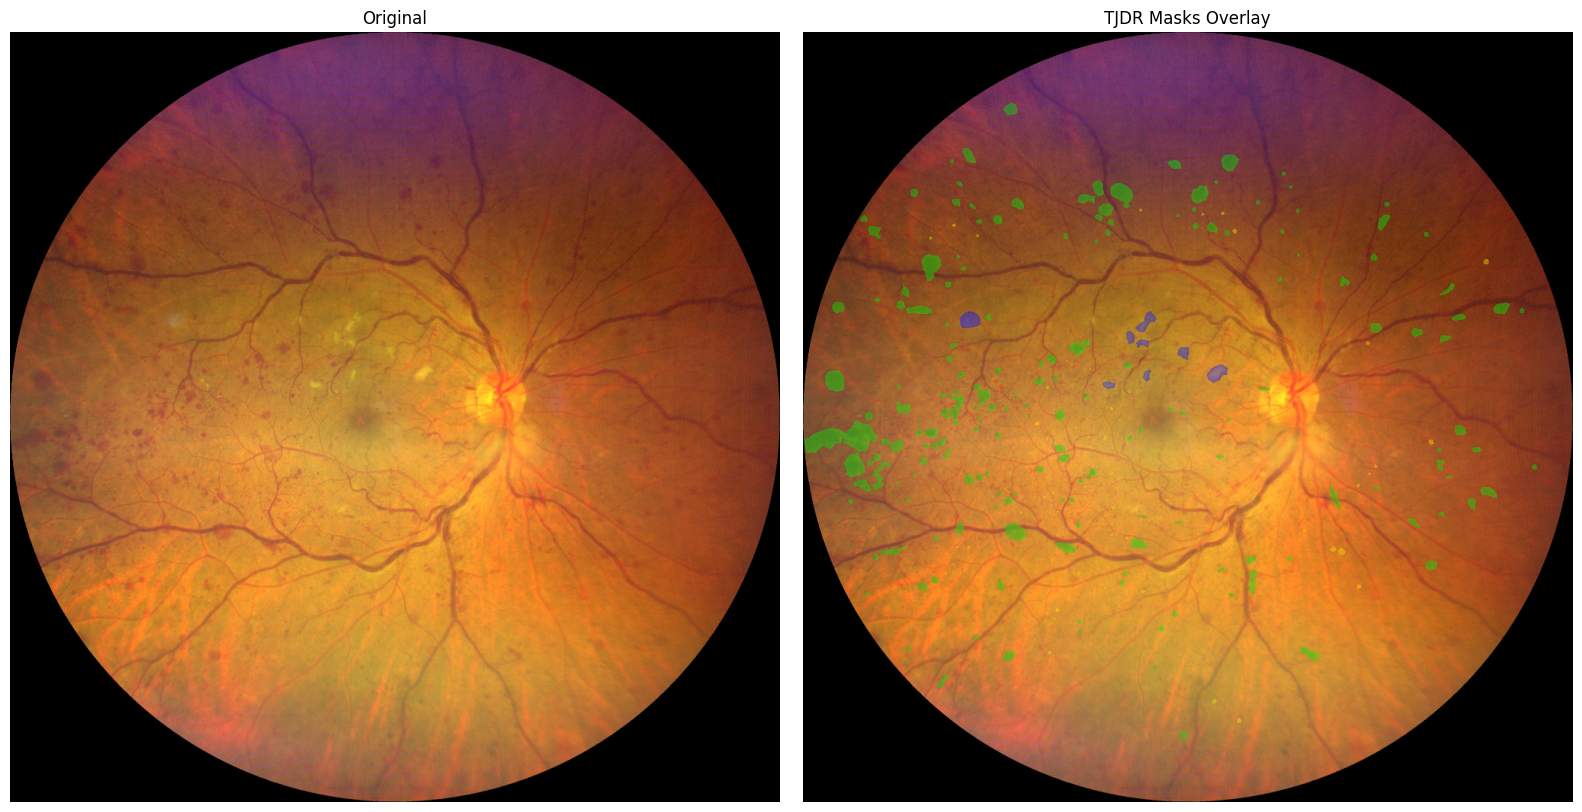

In [8]:
visualize_tjdr(
    image_path = "TJDR/train/image/TJDR_train_014.png",
    ann_path   = "TJDR/train/annotation/TJDR_train_014.png",
)